In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
k10 = KFold(n_splits=10, shuffle=True, random_state=123)

In [4]:
X_train = pd.read_csv('datasets/solubility/solTrainXtrans.csv', index_col=0)
X_test = pd.read_csv('datasets/solubility/solTestXtrans.csv', index_col=0)
y_train = pd.read_csv('datasets/solubility/solTrainY.csv', index_col=0).values.ravel()
y_test = pd.read_csv('datasets/solubility/solTestY.csv', index_col=0).values.ravel()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((951, 228), (951,), (316, 228), (316,))

In [4]:
X_train.NumCarbon.mean()

3.3239782000140847

Text(0,0.5,'solubility')

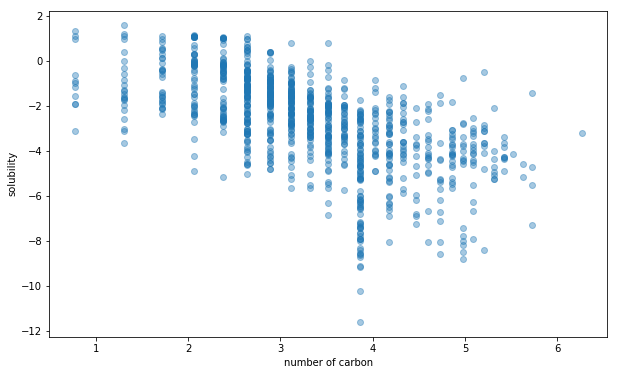

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(X_train.NumCarbon, y_train, 'o', alpha=.4)
plt.xlabel('number of carbon')
plt.ylabel('solubility')

In [12]:
nc = np.sort(X_train.NumCarbon.unique())
nc_split = (nc[:-1] + nc[1:]) * 0.5
nc_split

array([ 1.03588931,  1.51017623,  1.89395527,  2.22071076,  2.5075997 ,
        2.76475991,  2.99874671,  3.21407393,  3.41399788,  3.60095386,
        3.77681624,  3.94306199,  4.10087788,  4.25123348,  4.39493224,
        4.53264818,  4.66495293,  4.79233589,  4.91521967,  5.03397196,
        5.14891488,  5.26033239,  5.36847623,  5.47357071,  5.57581667,
        5.67539471,  5.99616819])

In [31]:
def get_splitting_points(arr):
    arr = np.sort(np.unique(arr))
    return (arr[:-1] + arr[1:]) * 0.5

def SSE(predictor_array, target_array, pred_split):
    idx0 = predictor_array < pred_split
    idx1 = predictor_array >= pred_split
    S1 = target_array[idx0]
    S2 = target_array[idx1]
    return ((S1 - S1.mean())**2).sum() + ((S2 - S2.mean())**2).sum()

def get_best_SSE_and_split_point(predictor, target):
    sp = get_splitting_points(predictor)
    assert len(sp)
    sse_list = [SSE(predictor, target, p) for p in sp]
    i_min = np.argmin(sse_list)
    return sse_list[i_min], sp[i_min]


def best_predictor(data, target):
    n_cols = data.shape[1]
    candidates = [get_best_SSE_and_split_point(data[:, i], target) + (i,) for i in range(n_cols)]
    return sorted(candidates, key=lambda x: x[0])[0]

In [32]:
best_predictor(X_train.values, y_train)

(2495.0031141955833, 3.7768162396100866, 218)

Text(0.5,1,'NumCarbon SSE by each possible splitting point')

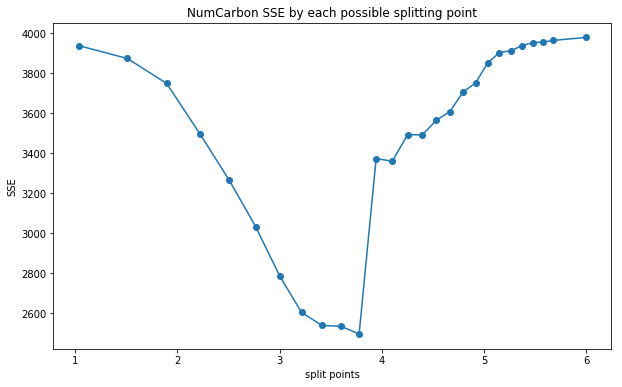

In [26]:
sse_by_split_points = [SSE(X_train.NumCarbon.values, y_train, p) for p in nc_split]


plt.figure(figsize=(10, 6))
plt.plot(nc_split, sse_by_split_points, 'o-')
plt.xlabel('split points')
plt.ylabel('SSE')
plt.title("NumCarbon SSE by each possible splitting point")

In [38]:
tree = DecisionTreeRegressor()
param = {'max_depth': np.arange(1, 10), 'min_samples_split': np.arange(2, 21, 2)}
tree_grid = GridSearchCV(tree, param, cv=k10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

In [39]:
tree_grid.fit(X_train.values, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   11.5s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [40]:
tree_grid.best_params_, np.sqrt(-tree_grid.best_score_)

({'max_depth': 7, 'min_samples_split': 18}, 0.90707303490434188)

In [42]:
np.sqrt(mean_squared_error(y_test, tree_grid.predict(X_test.values)))

0.81975813148268606

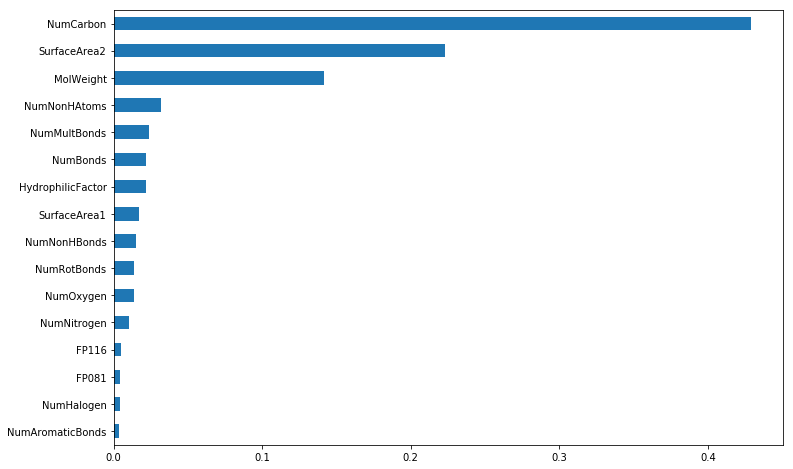

In [59]:
pd.Series(tree_grid.best_estimator_.feature_importances_, index=X_train.columns).sort_values()[-16:].plot.barh(figsize=(12, 8))

### Bagged Trees

In [6]:
from sklearn.ensemble import BaggingRegressor


In [10]:
tree_bagg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, 
                             max_features=int(np.sqrt(X_train.shape[1])), 
                             max_samples=0.65, oob_score=True)

In [11]:
tree_bagg.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=15,
         max_samples=0.65, n_estimators=50, n_jobs=1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [17]:
print("R^2 [oob]: {:.4f}".format(tree_bagg.oob_score_))

R^2 [oob]: 0.7800


In [16]:
print("RMSE[oob]: {:.4f}".format(np.sqrt(mean_squared_error(y_train, tree_bagg.oob_prediction_))))

RMSE [oob]: 0.9594


In [28]:
y_pred_list = []
for t, idx in zip(tree_bagg.estimators_, tree_bagg.estimators_features_):
    y_pred_list.append(t.predict(X_test.iloc[:, idx]))

In [29]:
y_pred_list = np.array(y_pred_list).cumsum(axis=0)
y_pred_list.shape

(50, 316)

In [32]:
y_pred_avg = y_pred_list / np.arange(1, y_pred_list.shape[0]+1)[:, None]

In [34]:
r2_by_n = [r2_score(y_test, y_pred) for y_pred in y_pred_avg]

Text(0,0.5,'R2 score')

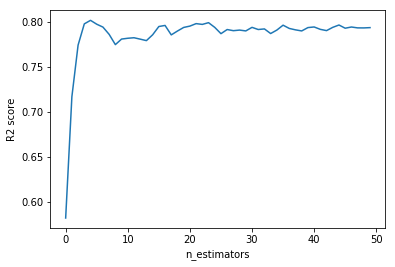

In [37]:
plt.plot(r2_by_n)
plt.xlabel('n_estimators')
plt.ylabel('R2 score')

Text(0,0.5,'RMSE')

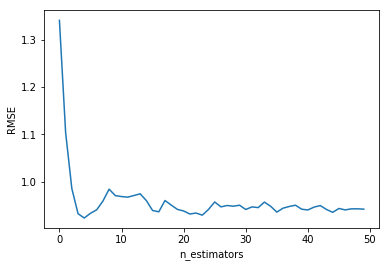

In [38]:
rmse_by_n = [np.sqrt(mean_squared_error(y_test, y_pred)) for y_pred in y_pred_avg]
plt.plot(rmse_by_n)
plt.xlabel("n_estimators")
plt.ylabel("RMSE")

### Random Forests

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
rf = RandomForestRegressor(n_estimators=50, oob_score=True)

In [41]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [42]:
rf.oob_score_

0.88910892788260643

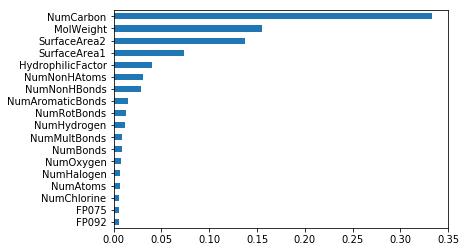

In [45]:
pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()[-18:].plot.barh()

In [56]:
y_preds = np.empty((len(rf.estimators_), len(y_test)), dtype=float)

for i, t in enumerate(rf.estimators_):
    y_preds[i] = t.predict(X_test)
    
y_preds = y_preds.cumsum(axis=0) / np.arange(1, len(y_preds)+1)[:, None]

In [50]:
r2_list = [r2_score(y_test, y_pred) for y_pred in y_preds]
rmse_list = [np.sqrt(mean_squared_error(y_test, y_pred)) for y_pred in y_preds]

Text(0,0.5,'R^2')

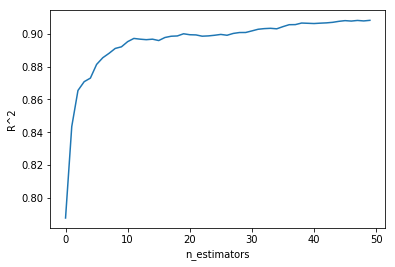

In [52]:
plt.plot(r2_list)
plt.xlabel('n_estimators')
plt.ylabel("R^2")

Text(0,0.5,'RMSE')

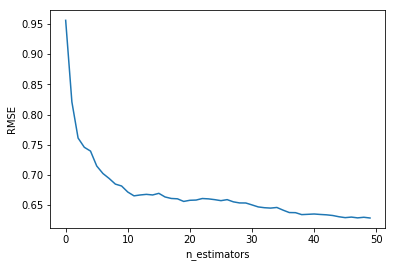

In [53]:
plt.plot(rmse_list)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

### Boosting

In [20]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

from xgboost import XGBRegressor, cv
from lightgbm import LGBMRegressor

In [6]:
ada_grid = GridSearchCV(AdaBoostRegressor(), {'n_estimators': [20, 50, 80, 100], 'learning_rate': [.001, .01, .1, 1.]}, 
                        cv=k10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [7]:
%%time
ada_grid.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   45.2s finished


CPU times: user 2.02 s, sys: 64.3 ms, total: 2.09 s
Wall time: 46.2 s


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [20, 50, 80, 100], 'learning_rate': [0.001, 0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [8]:
ada_grid.best_params_, np.sqrt(-ada_grid.best_score_)

({'learning_rate': 1.0, 'n_estimators': 80}, 0.82762525384864372)

Text(0.5,1,'Feature Importance: AdaBoostRegressor')

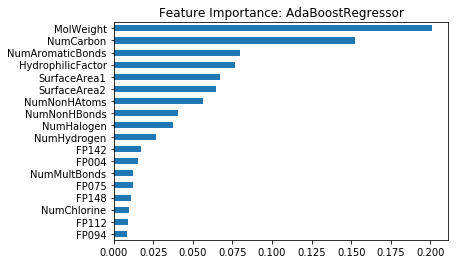

In [9]:
pd.Series(ada_grid.best_estimator_.feature_importances_, index=X_train.columns).sort_values()[-18:].plot.barh()
plt.title("Feature Importance: AdaBoostRegressor")

In [10]:
gbr_params = {
              'learning_rate': [.0125, .05, .1, .2, .5], 
              'n_estimators': [50, 100, 200],
              'max_depth': [1, 2, 3],
              'subsample': [.5, .8, 1.0],
             }

gbr_grid = GridSearchCV(GradientBoostingRegressor(), gbr_params, 
                        cv=k10, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

In [11]:
%%time
gbr_grid.fit(X_train, y_train)

Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  6.5min finished


CPU times: user 13.6 s, sys: 281 ms, total: 13.9 s
Wall time: 6min 34s


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.0125, 0.05, 0.1, 0.2, 0.5], 'max_depth': [1, 2, 3], 'subsample': [0.5, 0.8, 1.0], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [12]:
gbr_grid.best_params_, np.sqrt(-gbr_grid.best_score_)

({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8},
 0.60495561568066469)

In [13]:
np.sqrt(mean_squared_error(y_test, gbr_grid.predict(X_test)))

0.64577783421555834

In [21]:
xgb_params = {'max_depth': [3,5], 'learning_rate': [.01, .05, .1, .5]}

In [22]:
xgb_grid = GridSearchCV(XGBRegressor(), xgb_params, cv=k10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [ ]:
%%time
xgb_grid.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
